In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
from fytok.modules.Equilibrium import Equilibrium
from spdm.data.File import File
from spdm.view import View as sp_view
from spdm.data.Function import Function

WORKSPACE = "/home/salmon/workspace"  # "/ssd01/salmon_work/workspace/"
output_path = pathlib.Path(f"{WORKSPACE}/output/")

2024-02-05 14:27:23,638 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev102+gfad9d5c.d20240126, imas_version=v3_38_1_dirty)

 Run by salmon at 2024-02-05T14:27:23.471541.
 Job ID: fytok_salmon_surface_4753

###################################################################################################



In [2]:
data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")
astra_profiles = pd.read_excel(
    next(data_path.glob("*ASTRA.xls")).absolute().as_posix(), sheet_name=1, header=10, usecols="B:BN"
)
eqdsk_file = File(f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}", format="GEQdsk").read()

equilibrium = Equilibrium(
    f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}#equilibrium",
    # code={"parameters": {"psi_norm": np.linspace(0.01, 0.999, 128)}},
)

2024-02-05 14:27:23,842 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk
2024-02-05 14:27:23,923 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2024-02-05 14:27:23,951 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 


In [3]:
eq_profiles_2d = equilibrium.time_slice.current.profiles_2d
eq_profiles_1d = equilibrium.time_slice.current.profiles_1d


In [4]:
psi,surf=next(eq_profiles_2d._coord.find_surfaces(1.0))

2024-02-05 14:27:23,997 [    spdm]     INFO: Load module spdm.mesh.mesh_rectangular


2024-02-05 14:27:24,149 [    spdm]     INFO: Load module spdm.view.view_matplotlib


/home/salmon/.local/lib/python3.10/site-packages/IPython/core/formatters.py:367: FormatterWarning: image/svg+xml formatter returned invalid type <class 'matplotlib.figure.Figure'> (expected <class 'str'>) for object: <spdm.geometry.Curve.Curve object at 0x7fb0980b8280>
  warnings.warn(


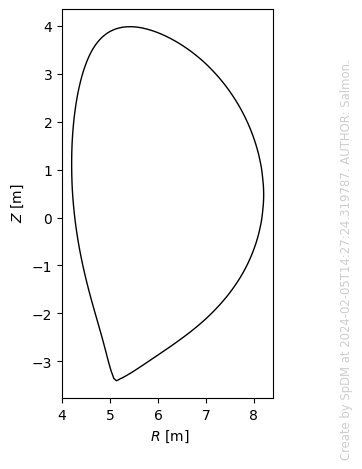

In [5]:
surf

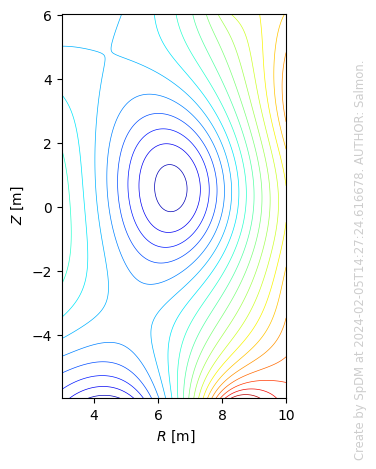

In [6]:
fig = sp_view.display(eq_profiles_2d.psi)

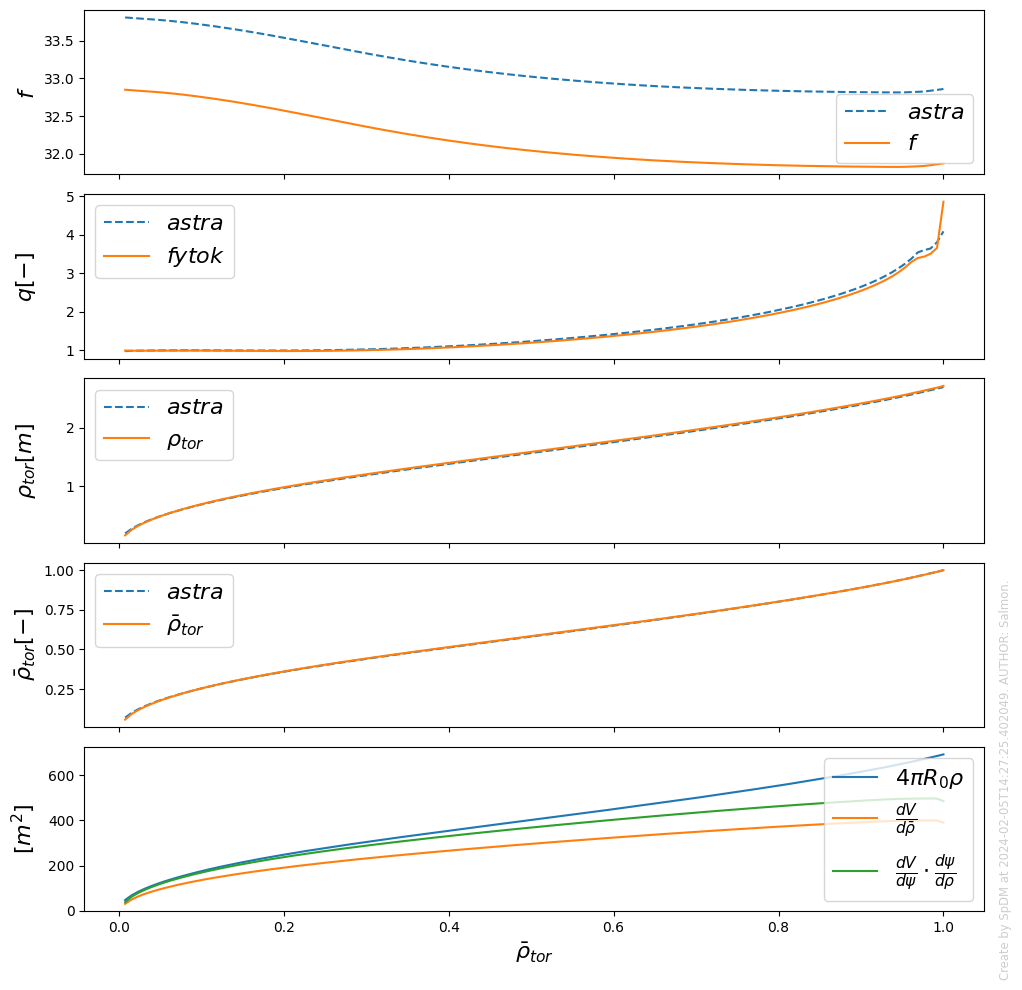

In [7]:
R0 = equilibrium.time_slice.current.vacuum_toroidal_field.r0
psi_axis = equilibrium.time_slice.current.global_quantities.psi_axis
psi_boundary = equilibrium.time_slice.current.global_quantities.psi_boundary
eq_profiles_1d = equilibrium.time_slice.current.profiles_1d

fig = sp_view.plot(
    eq_profiles_1d.psi_norm[1:],
    (
        [
            (
                Function(
                    eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/psi_norm"),
                    -eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/f"),
                ),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.f, "f"),
        ],
        {"y_label": r"$f$"},
    ),
    (
        [
            (
                Function(astra_profiles["xq"].values, astra_profiles["q"].values)(eq_profiles_1d.rho_tor_norm),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.q, {"label": r"fytok"}),
        ],
        {"y_label": r"$q [-]$"},
    ),
    (
        [
            (
                Function(astra_profiles["Fp"].values, astra_profiles["rho"].values),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.rho_tor),
        ],
        {
            "y_label": r"$\rho_{tor}[m]$",
        },
    ),
    (
        [
            (
                Function(astra_profiles["Fp"].values, astra_profiles["x"].values),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.rho_tor_norm),
        ],
        {
            "y_label": r"$\bar{\rho}_{tor}[-]$",
        },
    ),
    (
        [
            Function(
                astra_profiles["Fp"].values,
                4 * (scipy.constants.pi**2) * R0 * astra_profiles["rho"].values,
                label=r"$4\pi R_0 \rho$",
            ),
            (eq_profiles_1d.dvolume_drho_tor, {"label": r"$\frac{dV}{d\bar{\rho}}$"}),
            (
                (scipy.constants.pi * 2.0) * eq_profiles_1d.dvolume_dpsi * eq_profiles_1d.dpsi_drho_tor,
                r"$\frac{dV}{d\psi} \cdot \frac{d\psi}{d\rho}$",
            ),
        ],
        {"y_label": r"$[m^2]$"},
    ),
    x_label=r"$\bar{\rho}_{tor}$",
)

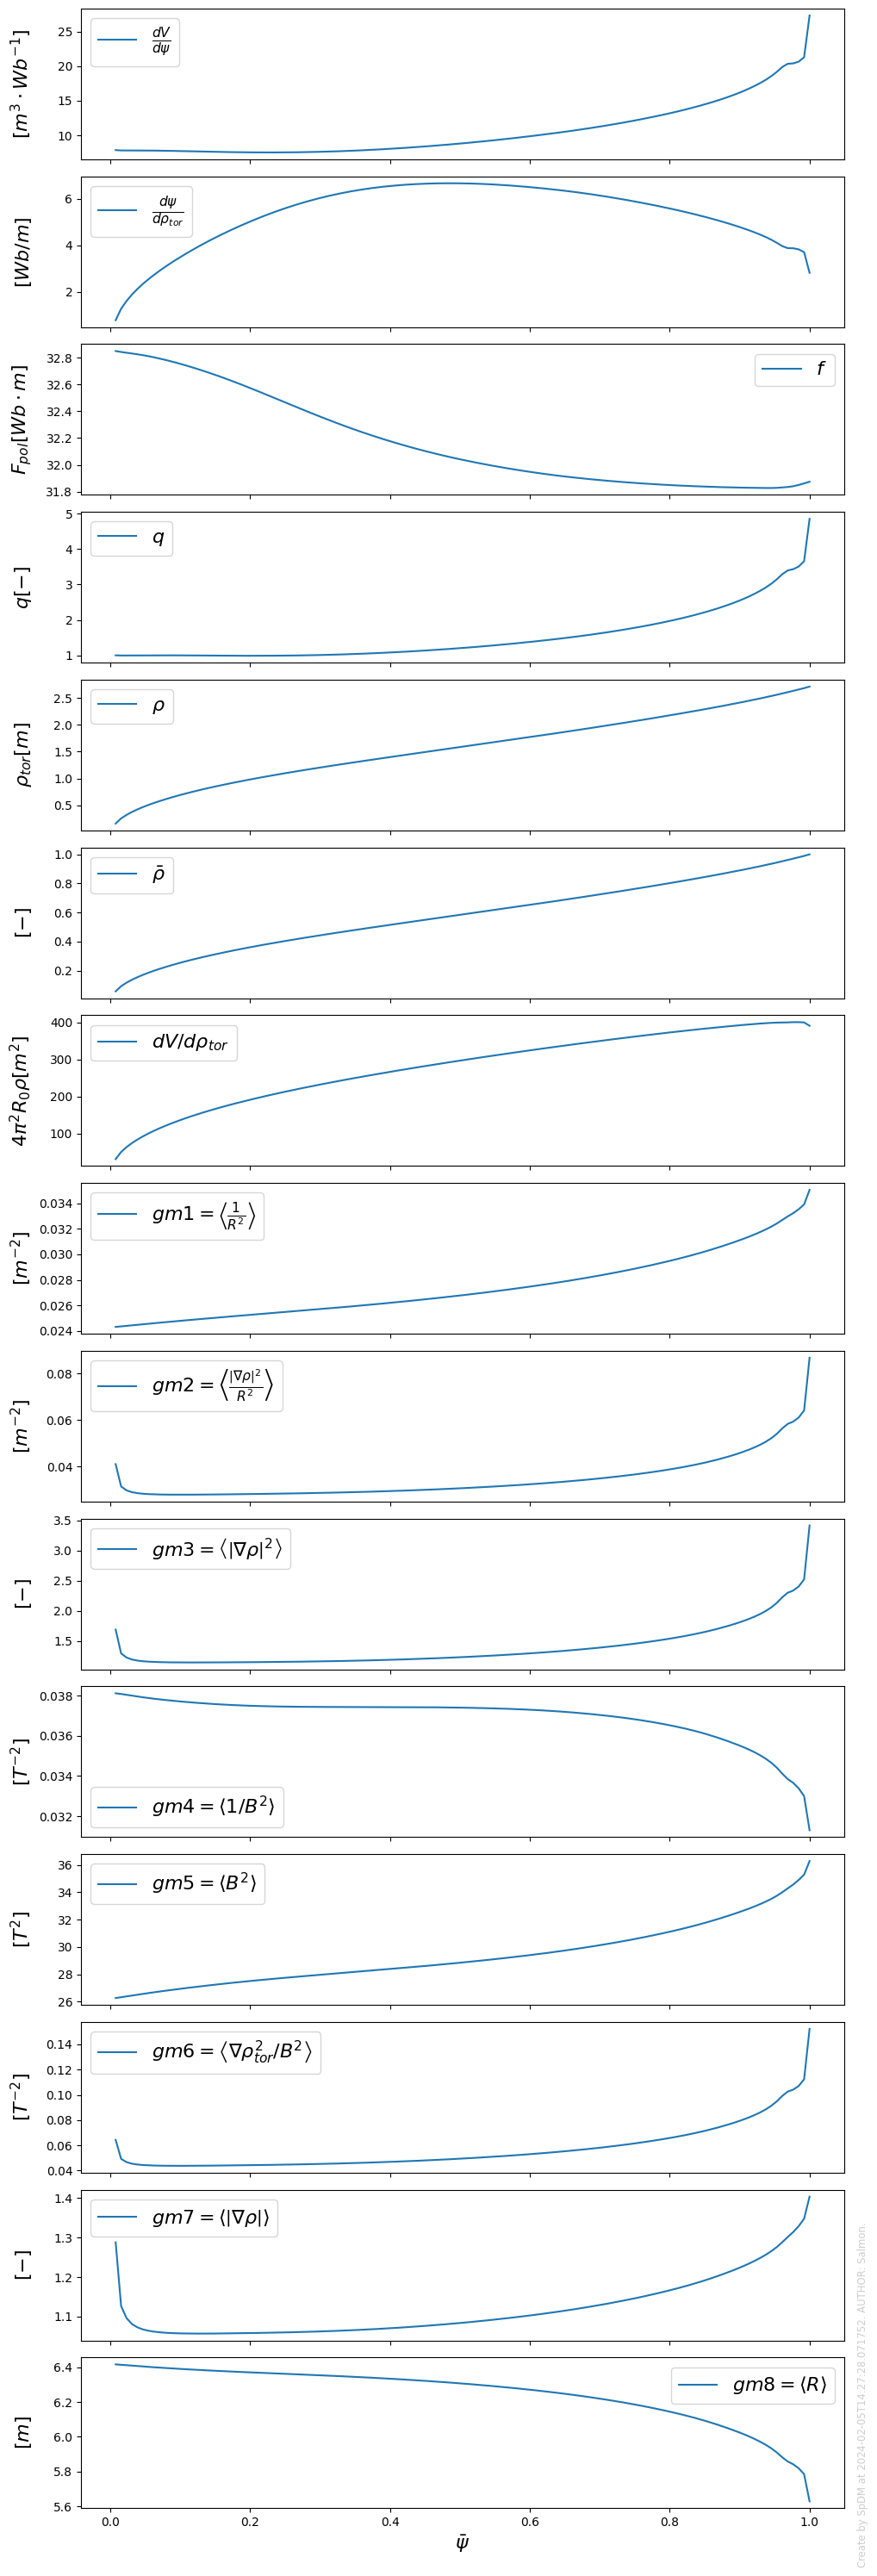

In [8]:
eq_profiles_1d = equilibrium.time_slice.current.profiles_1d
fig = sp_view.plot(  # plot tokamak geometric profile
    eq_profiles_1d.grid.psi_norm[1:],
    (eq_profiles_1d.dvolume_dpsi, r"$\frac{dV}{d\psi}$"),
    (eq_profiles_1d.dpsi_drho_tor, r"$\frac{d\psi}{d\rho_{tor}}$"),
    (eq_profiles_1d.f, {"y_label": r"$F_{pol} [Wb\cdot m]$"}),
    (eq_profiles_1d.q, {"y_label": r"$q [-]$"}),
    ((eq_profiles_1d.rho_tor, r"$\rho$"), {"y_label": r"$\rho_{tor}[m]$"}),
    ((eq_profiles_1d.rho_tor_norm, r"$\bar{\rho}$"), {"y_label": r"[-]"}),
    ((eq_profiles_1d.dvolume_drho_tor, r"$dV/d\rho_{tor}$"), {"y_label": r"$4\pi ^ 2 R_0 \rho[m ^ 2]$"}),
    (eq_profiles_1d.gm1, r"$gm1=\left<\frac{1}{R^2}\right>$"),
    (eq_profiles_1d.gm2, r"$gm2=\left<\frac{\left|\nabla \rho\right|^2}{R^2}\right>$"),
    (eq_profiles_1d.gm3, r"$gm3=\left<\left|\nabla \rho\right|^2\right>$"),
    (eq_profiles_1d.gm4, r"$gm4=\left<1/B^2\right>$"),
    (eq_profiles_1d.gm5, r"$gm5=\left<B^2\right>$"),
    (eq_profiles_1d.gm6, r"$gm6=\left<\nabla \rho_{tor}^2/ B^2 \right>$"),
    (eq_profiles_1d.gm7, r"$gm7=\left<\left|\nabla \rho\right|\right>$"),
    (eq_profiles_1d.gm8, r"$gm8=\left<R\right>$"),
    x_label=r"\bar{\psi}",
)

2024-02-05 14:27:31,688 [    spdm]    ERROR: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:162:_draw: ignore unsupported geometry FyEqAnalyze <FyEqAnalyze name='unnamed' />! 
Traceback (most recent call last):
  File "/home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py", line 157, in _draw
    geo = geo.__geometry__(view_point=view_point, **kwargs)
  File "/home/salmon/workspace/fytok/python/fytok/modules/Equilibrium.py", line 502, in __geometry__
    return self.time_slice.current.__geometry__(*args, **kwargs)
  File "/home/salmon/workspace/fytok/python/fytok/modules/Equilibrium.py", line 433, in __geometry__
    raise error
  File "/home/salmon/workspace/fytok/python/fytok/modules/Equilibrium.py", line 427, in __geometry__
    geo["boundary_separatrix"] = self.boundary_separatrix.outline
  File "/home/salmon/workspace/fytok/SpDM/python/spdm/data/sp_property.py", line 327, in __get__
    value = instance._find_(
  File "/home/salmon/workspace/

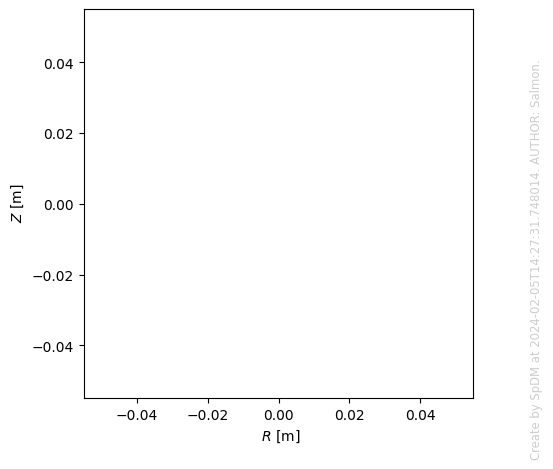

In [9]:
fig=sp_view.display(equilibrium)